Verify that the direct TMS stim works as intended

Components to verify:
 - Probability parameter in drives works as expected
    - Done; verified by inspecting the animation when applying direct stim alone and distal drive alone. Cells are randomly stimulated according to the specified probability.
    - When the net is disconnected from itself, the distal drive results in different activation times for cells at different distances from the center of the column due to the space constant. What is the justification for this? What aspect of in-vivo dynamics does this model? Is it applicable to TMS? 
 - Direct stim of soma works as expected
    - Done; verified by inspecting the animation when applying direct stim alone. Depolarization originates at the soma and travels up the apical dendrite. 
    - AMPA and NMDA drives lasts too long. L5Pyr cells burst with 3 spikes using either.

Also tune direct stim to soma so that it spikes quickly (brief, strong current injection)
 - Direct activation should also override any hyperpolarization that the cell is experiencing so that a spike is registered (that's the whole point)

Base code from [Nick Tolley's Animating HNN Simulations tutorial](https://jonescompneurolab.github.io/textbook/content/08_using_hnn_api/animating_hnn_simulations.html)

In [15]:
import os.path as op

import matplotlib.pyplot as plt
%matplotlib ipympl

import hnn_core
from hnn_core import jones_2009_model, simulate_dipole, read_params
from hnn_core.network_models import add_erp_drives_to_jones_model

In [16]:
net = jones_2009_model(mesh_shape=(1, 1))
net.clear_connectivity() # To isolate the effects of the stimulation

# Note that we move the cells further apart to allow better visualization of
# the network (default inplane_distance=1.0 µm).
net.set_cell_positions(inplane_distance=300)

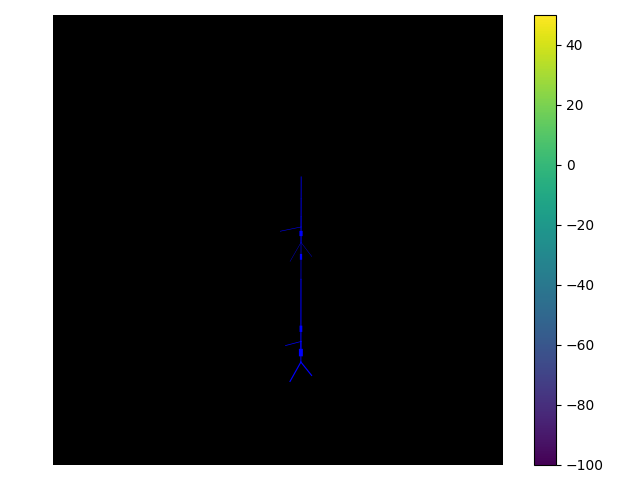

In [17]:
from hnn_core.viz import NetworkPlotter

net_plot = NetworkPlotter(net)

In [18]:
# net_plot.azim = 45
# net_plot.elev = 40
# net_plot.fig

In [19]:
# # Add distal w/ probability
# net.add_evoked_drive(
#     name="tms_distal",
#     mu=0.5,
#     sigma=0,
#     numspikes=1,
#     location="distal",
#     # n_drive_cells=None,
#     # cell_specific=None,
#     weights_ampa={'L2_basket': 0.0024741719999999997, 'L2_pyramidal': 0.0031460039999999996, 'L5_pyramidal': 0.030831731999999997},
#     weights_nmda={'L2_basket': 0.039215124, 'L2_pyramidal': 0.004143708, 'L5_pyramidal': 0.006008543999999999},
#     # space_constant=None,
#     synaptic_delays={'L2_basket': 0.1, 'L2_pyramidal': 0.1, 'L5_pyramidal': 0.1},
#     probability=0.5,
# )
# Edit syns of each pyramidal cell soma to be able to receive ampa and nmda synapse approximating backpropagating AP from axon
net.cell_types['L2_pyramidal'].sections['soma'].syns = ['gabaa', 'gabab', 'ampa', 'nmda']
net.cell_types['L5_pyramidal'].sections['soma'].syns = ['gabaa', 'gabab', 'ampa', 'nmda']
# Add direct w/ cell-type specific probability
net.add_evoked_drive(
    name="tms_direct",
    mu=0.5, # Tune
    sigma=0, # Tune
    numspikes=1,
    location="soma",
    # n_drive_cells=None,
    # cell_specific=None,
    weights_ampa=   {'L2_basket':    0.002, 
                     'L2_pyramidal': 0.003, 
                     'L5_basket':    0.002,
                     'L5_pyramidal': 0.00}, # Tune to mimic real cell response 
    weights_nmda=   {'L2_basket':    0.0, 
                     'L2_pyramidal': 0.0, 
                     'L5_basket':    0.0,
                     'L5_pyramidal': 0.003}, # Make 0; probably want to just do ampa
    space_constant=1e6, # Every point in space should be equivalent; large constant effectively does this
    synaptic_delays=0., # Maybe should be 0
    probability=    {'L2_basket':    0.01,
                     'L2_pyramidal': 0.01,
                     'L5_basket':    0.01,
                     'L5_pyramidal': 1.}, # Tune
)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
[[0.5]]


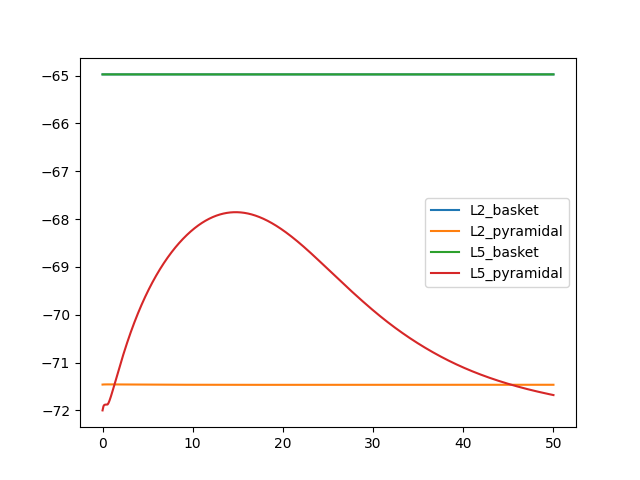

In [20]:

dpl = simulate_dipole(net, tstop=50, record_vsec='all')

fig, ax = plt.subplots()
times = net.cell_response._times
vsec = net.cell_response._vsec[0]
for cell in vsec.values(): ax.plot(times, cell['soma'])
ax.legend(['L2_basket', 'L2_pyramidal', 'L5_basket', 'L5_pyramidal'])
print(net.cell_response.spike_times)

# net_plot = NetworkPlotter(net)  # Reinitialize plotter with simulated network


In [21]:
# If you want to save the animation to a file, then uncomment the code in this cell.
# net_plot.xlim = (400, 1600)
# net_plot.ylim = (400, 1600)
# net_plot.zlim = (-500, 1600)
# net_plot.azim = 225
# net_plot.export_movie('animation_demo.gif', dpi=100, fps=30, interval=100)